In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [3]:
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_70-80.csv", index_col=0)

In [4]:
mask = ((ppmi_ad.obs['Age_Group'] == '70-80') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [5]:
ppmi_ad = ppmi_ad[mask]

In [6]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_3545/3785693463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


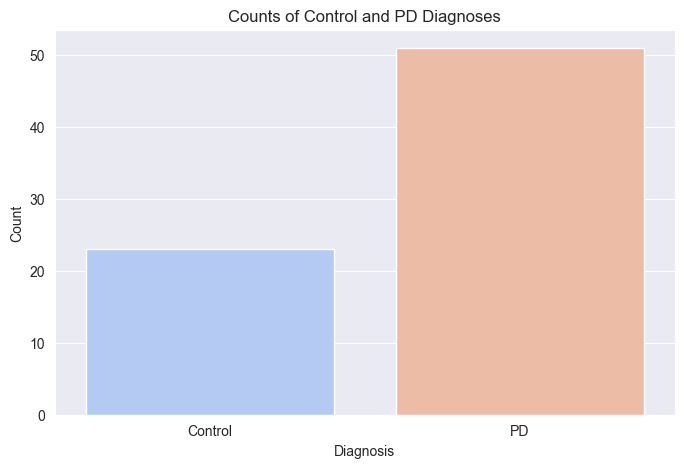

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [8]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Smote will create synthetic samples for the minority class. SMOTE stands for synthetic minority Over-sampling technique.

In [10]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [11]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print(np.bincount(y_res))
print(np.bincount(y_train))

/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[41 41]
[18 41]


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [13]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [14]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.90      0.95        10

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15



In [15]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.980
PR-AUC: 0.991


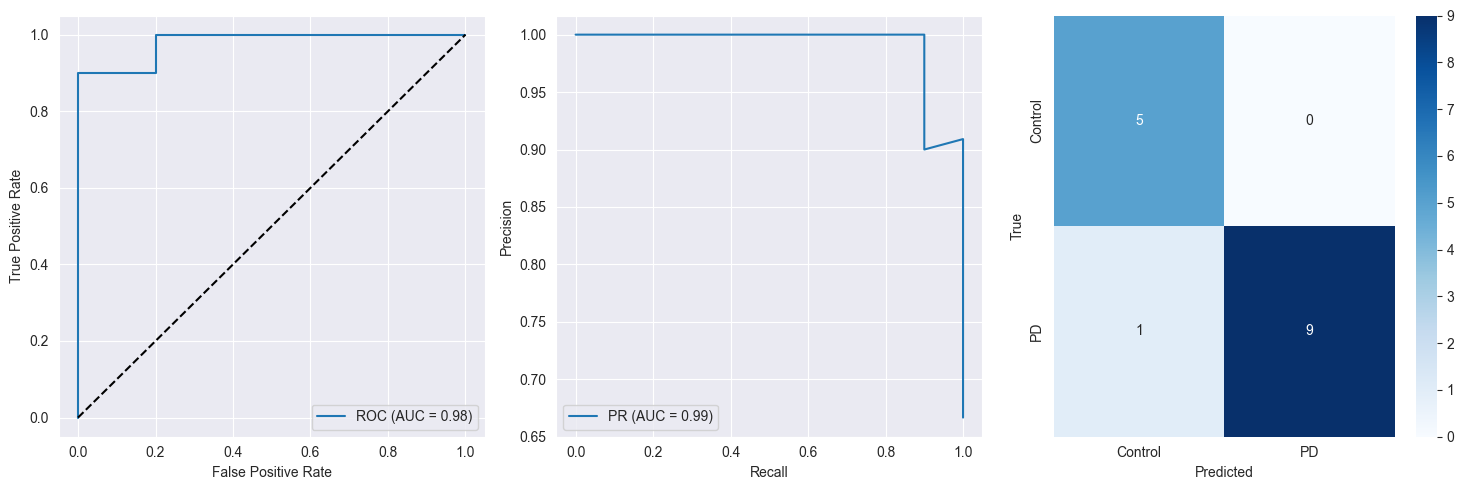

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [17]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.963 ± 0.057
PR-AUC: 0.984 ± 0.027


In [18]:
coefficients = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'coefficient': lr_pipeline.named_steps['lr'].coef_[0],
    'abs_coef': np.abs(lr_pipeline.named_steps['lr'].coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 40 predictive genes:")
print(coefficients.head(40)[['gene_symbol', 'coefficient']])


Top 40 predictive genes:
                        gene_symbol  coefficient
ENSG00000229009.7        TMPRSS11GP     0.113773
ENSG00000205090.8           TMEM240    -0.105385
ENSG00000229118.1   ENSG00000229118    -0.104625
ENSG00000248174.5         LINC02268    -0.095762
ENSG00000243775.2            OSTCP1     0.093811
ENSG00000257731.2           SSBP3P4    -0.092837
ENSG00000265533.1          DSEL-AS1    -0.092289
ENSG00000224589.1            ORC1P1    -0.091512
ENSG00000266158.2         RN7SL785P    -0.091243
ENSG00000249744.1         ZCCHC10P2    -0.090499
ENSG00000167858.12            TEKT1    -0.090108
ENSG00000156564.8             LRFN2    -0.088247
ENSG00000182324.6            KCNJ14     0.088169
ENSG00000241114.1   ENSG00000241114    -0.086700
ENSG00000282863.1   ENSG00000282863    -0.085684
ENSG00000275223.1   ENSG00000275223     0.084934
ENSG00000269125.1   ENSG00000269125    -0.084874
ENSG00000212354.1        RNU6-1242P    -0.084856
ENSG00000227987.1   ENSG00000227987    -0.0

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_3545/888752835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


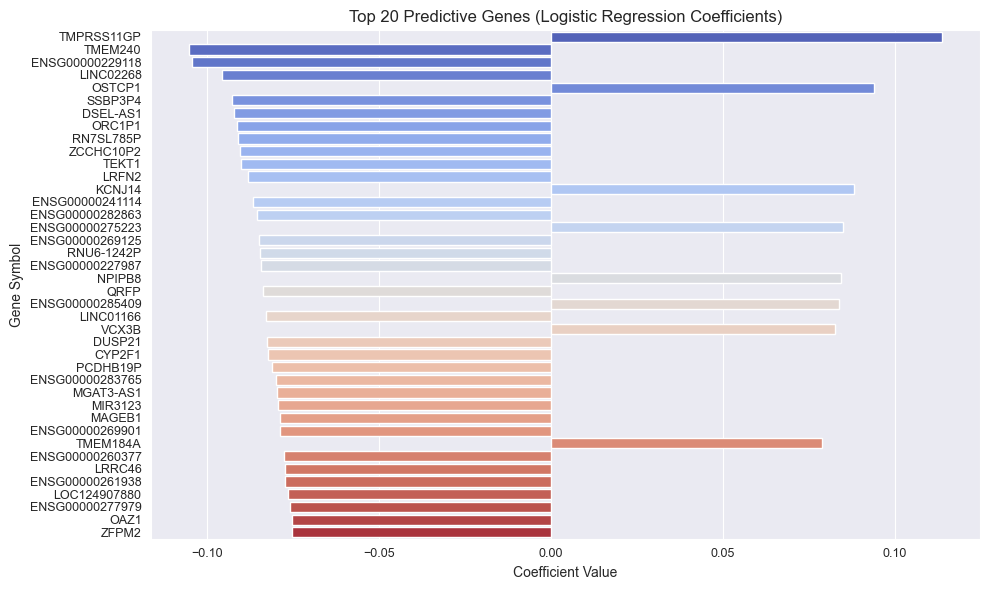

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients.head(40),
    x='coefficient',
    y='gene_symbol',
    palette='coolwarm'
)
plt.title('Top 20 Predictive Genes (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Precision-Recall Tradeoff (best for imbalanced data)

In [20]:
optimal_idx = np.argmax(precision * recall)
optimal_threshold_pr = thresholds[optimal_idx]
print(f"Optimal PR Threshold: {optimal_threshold_pr:.3f}")

Optimal PR Threshold: 0.027


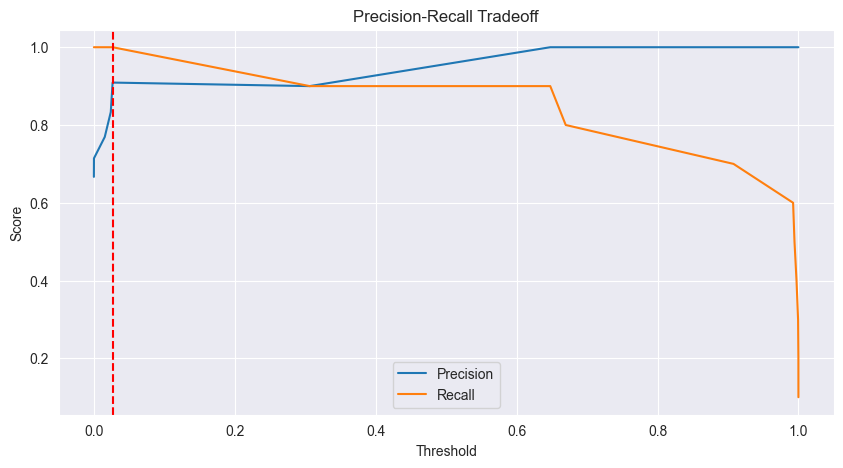

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [23]:
final_threshold = optimal_threshold_pr
y_pred_custom = (y_proba >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [50, 24]

In [45]:
y_pred_custom

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [46]:
y_proba

array([9.99948294e-01, 2.69027376e-02, 9.99935072e-01, 2.15013449e-07,
       7.28956514e-05, 1.59122278e-02, 9.99961485e-01, 9.99939536e-01,
       5.06101700e-08, 9.99944119e-01])